C:\Users\adity\AppData\Local\Temp\ipykernel_15696\1909916470.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buy0 = float(ready[0] - p[0] - FEE)
C:\Users\adity\AppData\Local\Temp\ipykernel_15696\1909916470.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buy_today = float(ready[t] - p[t] - FEE)
C:\Users\adity\AppData\Local\Temp\ipykernel_15696\1909916470.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sell_today = float(hold[t-1] + p[t] - FEE)
C:\Use

Optimal DP profit: 906.23  |  Trades: 364  |  Saved -> C:\Users\adity\Downloads\Learn_DSA_Quant\Level-26\AAPL_dp_trades.csv


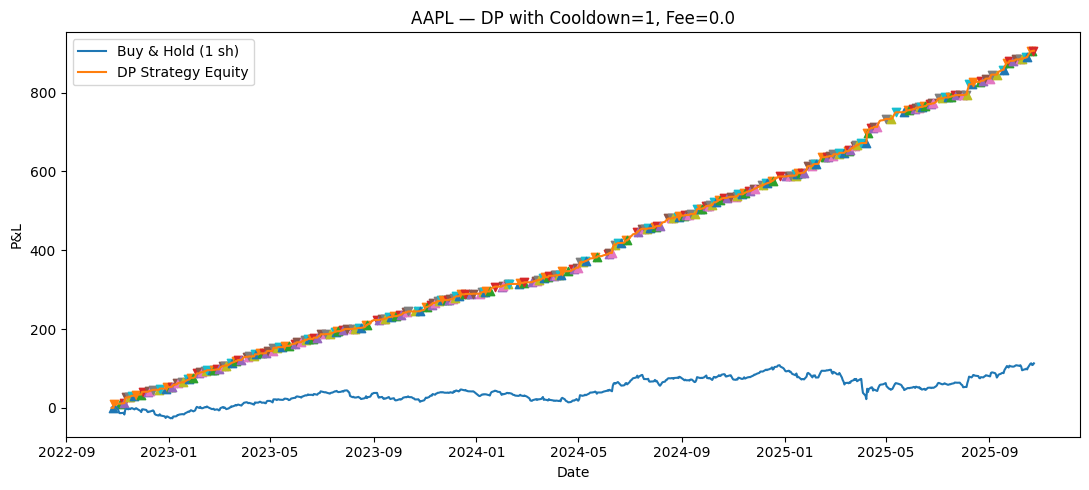


Trades:
      date action   t      price
2022-10-27    BUY   2 142.549820
2022-10-28   SELL   3 153.319778
2022-11-04    BUY   8 136.455551
2022-11-08   SELL  10 137.559967
2022-11-09    BUY  11 132.994339
2022-11-11   SELL  13 147.618134
2022-11-14    BUY  14 146.217865
2022-11-15   SELL  15 147.953400
2022-11-16    BUY  16 146.720764
2022-11-18   SELL  18 149.186005
2022-11-21    BUY  19 145.951599
2022-11-23   SELL  21 148.969055
2022-11-29    BUY  24 139.206741
2022-12-01   SELL  26 146.247498
2022-12-07    BUY  30 138.979935
2022-12-08   SELL  31 140.666168
2022-12-09    BUY  32 140.182999
2022-12-13   SELL  34 143.446976
2022-12-20    BUY  39 130.460083
2022-12-21   SELL  40 133.566315
2022-12-28    BUY  44 124.287163
2022-12-30   SELL  46 128.123062
2023-01-03    BUY  47 123.330643
2023-01-04   SELL  48 124.602715
2023-01-05    BUY  49 123.281342
2023-01-11   SELL  53 131.633545
2023-01-12    BUY  54 131.554672
2023-01-17   SELL  56 134.049484
2023-01-18    BUY  57 133.329605
2

In [2]:
# Step 26 — DP Optimal Trade Scheduling with Cooldown (fixed scalar handling)

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from pathlib import Path

# ----------------- User params -----------------
TICKER   = "AAPL"
YEARS    = 3
COOLDOWN = 1          # sessions you must wait after SELL before next BUY
FEE      = 0.00       # per transaction fee (applied on BUY and SELL)
OUT_DIR  = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-26")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ----------------- Data load (adj close) -----------------
def download_close(ticker: str, years: int = 3) -> pd.Series:
    df = yf.download(ticker, period=f"{years}y", interval="1d",
                     auto_adjust=True, progress=False)
    if df.empty:
        return pd.Series(dtype=float)
    col = "Close" if "Close" in df.columns else ("Adj Close" if "Adj Close" in df.columns else None)
    if col is None:
        return pd.Series(dtype=float)
    s = df[col].dropna().astype(float)
    s = s[~s.index.duplicated(keep="last")]
    return s

def make_synth(n=3*252, seed=26):
    rng = np.random.default_rng(seed)
    dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n)
    mu, vol = 0.12, 0.25  # annualized drift/vol
    dt = 1/252
    r = (mu - 0.5*vol**2)*dt + vol*np.sqrt(dt)*rng.standard_normal(n)
    p = 100*np.exp(np.cumsum(r))
    return pd.Series(p, index=dates, name="SYNTH")

px = download_close(TICKER, YEARS)
if px.empty:
    print("Using synthetic price series fallback.")
    px = make_synth()
    TICKER = "SYNTH"

px = px.sort_index()
p  = px.to_numpy(dtype=float)   # 1-D ndarray of floats
n  = int(len(p))

# ----------------- DP with cooldown queue + backpointers -----------------
ready = np.full(n, -np.inf, dtype=float)
hold  = np.full(n, -np.inf, dtype=float)

# backpointers
ready_from = [("INIT", -1)] * n     # ("KEEP", t-1) or ("COOLDONE", sell_day) or INIT
hold_from  = [("INIT", -1)] * n     # ("HOLD", t-1) or ("BUY", t)

coolq = deque()  # (expire_day, profit_value(float), sell_day)

# init day 0
ready[0] = 0.0
ready_from[0] = ("INIT", -1)

buy0 = float(ready[0] - p[0] - FEE)
hold[0] = buy0 if buy0 > -np.inf else -np.inf
hold_from[0] = ("BUY", 0) if np.isfinite(hold[0]) else ("INIT", -1)

for t in range(1, n):
    # 1) start from keeping prior ready
    rdy = float(ready[t-1])
    src = ("KEEP", t-1)

    # 2) pop any sells whose cooldown expires now; take best
    expired_best = -np.inf
    expired_best_sell_day = -1
    while coolq and coolq[0][0] <= t:
        exp_day, val, sday = coolq.popleft()
        val = float(val)
        if val > expired_best:
            expired_best = val
            expired_best_sell_day = sday

    if expired_best > rdy:
        rdy = expired_best
        src = ("COOLDONE", expired_best_sell_day)

    ready[t] = float(rdy)
    ready_from[t] = src

    # 3) hold: keep or buy
    keep_hold = float(hold[t-1])
    buy_today = float(ready[t] - p[t] - FEE)
    if buy_today > keep_hold:
        hold[t] = float(buy_today)
        hold_from[t] = ("BUY", t)
    else:
        hold[t] = float(keep_hold)
        hold_from[t] = ("HOLD", t-1)

    # 4) sell today (from yesterday's hold)
    if np.isfinite(hold[t-1]):
        sell_today = float(hold[t-1] + p[t] - FEE)
        exp_day = t + COOLDOWN
        coolq.append((exp_day, sell_today, t))

opt_profit = float(ready[-1])

# ----------------- Backtracking -----------------
trades = []  # [{"action":"BUY"/"SELL","t":int,"price":float}]
state = ("READY", n-1)
t = n-1
while t >= 0:
    if state[0] == "READY":
        how, idx = ready_from[t]
        if how == "INIT":
            break
        elif how == "KEEP":
            t = idx
            state = ("READY", t)
        elif how == "COOLDONE":
            sell_day = idx
            if sell_day >= 0:
                trades.append({"action":"SELL","t":int(sell_day),"price":float(p[sell_day])})
                t = sell_day - 1
                if t < 0: break
                state = ("HOLD", t)
            else:
                break
        else:
            break
    elif state[0] == "HOLD":
        how, idx = hold_from[t]
        if how == "HOLD":
            t = idx
            state = ("HOLD", t)
        elif how == "BUY":
            trades.append({"action":"BUY","t":int(t),"price":float(p[t])})
            state = ("READY", t)
        else:
            break
    else:
        break

trades = list(reversed(trades))

# enforce alternating BUY/SELL & cooldown
cleaned = []
expect = "BUY"
last_sell_t = -10**9
for tr in trades:
    act = tr["action"]
    tt  = int(tr["t"])
    if expect == "BUY" and act == "BUY":
        # respect cooldown relative to last SELL
        if tt >= last_sell_t + COOLDOWN:
            cleaned.append(tr)
            expect = "SELL"
    elif expect == "SELL" and act == "SELL":
        cleaned.append(tr)
        last_sell_t = tt
        expect = "BUY"
# drop trailing unmatched BUY
if cleaned and cleaned[-1]["action"] == "BUY":
    cleaned.pop()
trades = cleaned

# ----------------- Equity curve (strict scalar ops) -----------------
equity = []
cash = 0.0
pos  = 0

# fast lookup of trades by day, and deterministic order: BUY before SELL
trades_by_day = defaultdict(list)
for tr in trades:
    trades_by_day[int(tr["t"])].append(tr)
for day in trades_by_day:
    # enforce BUY then SELL order if both appear (shouldn’t after cleaning, but safe)
    trades_by_day[day].sort(key=lambda x: 0 if x["action"]=="BUY" else 1)

for i, price in enumerate(p):
    price = float(price)
    todays = trades_by_day.get(i, [])
    for tr in todays:
        if tr["action"] == "BUY" and pos == 0:
            cash = float(cash - price - FEE)
            pos = 1
        elif tr["action"] == "SELL" and pos == 1:
            cash = float(cash + price - FEE)
            pos = 0
    eq = float(cash + (price if pos==1 else 0.0))
    equity.append(eq)

equity = np.array([float(x) for x in equity], dtype=float)
equity = equity - float(equity[0])

bh_equity = p - float(p[0])

# ----------------- Output & plots -----------------
trades_df = pd.DataFrame(trades)
if not trades_df.empty:
    trades_df["date"] = [px.index[int(t)] for t in trades_df["t"]]
    trades_df = trades_df[["date","action","t","price"]]

trades_csv = OUT_DIR / f"{TICKER}_dp_trades.csv"
trades_df.to_csv(trades_csv, index=False)
print(f"Optimal DP profit: {opt_profit:.2f}  |  Trades: {len(trades)}  |  Saved -> {trades_csv}")

plt.figure(figsize=(11,5))
plt.plot(px.index, bh_equity, label="Buy & Hold (1 sh)")
plt.plot(px.index, equity,    label="DP Strategy Equity")
for tr in trades:
    d = px.index[int(tr["t"])]
    y = float(equity[int(tr["t"])])
    plt.scatter([d],[y], marker="^" if tr["action"]=="BUY" else "v")
plt.title(f"{TICKER} — DP with Cooldown={COOLDOWN}, Fee={FEE}")
plt.xlabel("Date"); plt.ylabel("P&L")
plt.legend(); plt.tight_layout(); plt.show()

if not trades_df.empty:
    print("\nTrades:")
    print(trades_df.to_string(index=False))
else:
    print("\nNo trades found (params may favor staying flat).")
